# Figures and analyses for propgage paper

Figures and statistical tests appear in the order that they do in the manuscript. Supplementary figures are at the end.

Note that we import a package from R for Hartigan's dip test, i.e. you will need a working installation of R configured to work with python to run that part of the notebook.

### Import packages

In [1]:
import os
import sys
sys.path.append('/Users/JFisher/Dropbox/Flinders/FAME/PhispyAnalysis-main/prophage-distributions/')

import pandas as pd
import numpy as np

import math
import re
import string

from PhiSpyAnalysis import theils_u, DateConverter, printmd
from PhiSpyAnalysis import read_phages, read_gtdb, read_checkv, read_base_pp, read_categories, read_metadata, read_transposons
from Bio import Phylo

# Statts packages
from scipy.stats import pearsonr, f_oneway, mannwhitneyu
import scipy as scp
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, LeaveOneGroupOut
from sklearn import metrics
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd, tukeyhsd, MultiComparison
from statsmodels.multivariate.manova import MANOVA
from sklearn import decomposition
from sklearn.ensemble import RandomForestClassifier

# for parsing collection dates
from dateutil.parser import parse, ParserError
import pytz

import subprocess
import gzip
import pickle as pkl

# import function dc which converts a date to a year and decimal (e.g. 1/1/1900 is 1900.00)
dc = DateConverter()


### Import R related packages

If you don't have R, don't import this section - it just means that you won't be able to plot some of Fig 2

In [2]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects import Formula


### Import plot tools and figure settings
Matplotlib and seaborn plus colour-blind friendly colour scheme

In [3]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False

import seaborn as sns
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mtick

formatter = mtick.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm, Normalize
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib import colors


colourDict = dict(zip(['rose', 'indigo', 'sand', 'green', 'cyan', 'wine', 'teal', 'olive', 'purple', 'pale_grey', 'black'],
                 ['#CC6677', '#332288', '#DDCC77', '#117733', '#88CCEE',
                    '#882255', '#44AA99', '#999933', '#AA4499', '#DDDDDD',
                    '#000000']))

##### Matplotlib formatting. Latex may be required.

In [4]:
fig_width_pt = 410.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean       # height in inches
fig_size =  [fig_width,fig_height]
params = {'backend': 'ps','axes.labelsize': 8,'font.size': 8,
          'legend.fontsize': 8,'xtick.labelsize': 8,'ytick.labelsize': 8,
          'text.usetex': True,'figure.figsize': fig_size, 'axes.linewidth':0.3}

# Depending on your latex installation, one or both of these may be required
mpl.rcParams['text.latex.preamble'] = [r'\usepackage[cm]{sfmath}',r'\usepackage{underscore}']
plt.rcParams["text.latex.preamble"].join([r'\usepackage[cm]{sfmath}',r'\usepackage{underscore}'])

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'cm'
mpl.rcParams['text.usetex']=False
mpl.rcParams['figure.dpi'] = 300


mpl.rcParams.update(params)

<ipython-input-4-8f08e9c82c52>:12: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  mpl.rcParams['text.latex.preamble'] = [r'\usepackage[cm]{sfmath}',r'\usepackage{underscore}']


### Other useful functions and methods

In [5]:
# Change seaborn figure level plots to something which can be used in gridspec
class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

# 
class MathTextSciFormatter(mtick.Formatter):
    def __init__(self, fmt="%1.0e"):
        self.fmt = fmt
    def __call__(self, x, pos=None):
        s = self.fmt % x
        decimal_point = '.'
        positive_sign = '+'
        tup = s.split('e')
        significand = tup[0].rstrip(decimal_point)
        sign = tup[1][0].replace(positive_sign, '')
        exponent = tup[1][1:].lstrip('0')
        if exponent:
            exponent = '10^{%s%s}' % (sign, exponent)
        if significand and exponent:
            s =  r'%s{\times}%s' % (significand, exponent)
        else:
            s =  r'%s%s' % (significand, exponent)
        return "${}$".format(s)

# Search for word metagenome
def metagenomeStatus(x):
    if 'metagenome' in x:
        return "Yes" 
    else: 
        return "No"

# Put sample date in as isolation date 
def updateDate(x,magDateDict):
#     c = .isnan()
    if np.isnan(x['isolation_date']):
        y = magDateDict.get(x['assembly_accession'])
        return y
    else:
        y = x['isolation_date']
        return y


# Import the datasets. 

We have two data sets: `small` is just 99 genomes and 1,561 phages and should run quickly for development. 
Max contig specifies the maximimum number of contigs. Set to 100 to ensure acceptable quality genomes.

In [6]:
# Read the genome phage stats file
phagestatsdf = pd.read_csv('../data/phage_stats.20220620.tsv', sep='\t')

# Filter genomes so only those with 100 or fewer are in the analysis
maxContig = 100 
phagestatsdf = phagestatsdf[phagestatsdf['Genome Contigs'] <= maxContig]

# Remove genbank files that do not have protein sequences.
phagestatsdf = phagestatsdf[phagestatsdf['Note'] == 'Complete'] # Make sure complete genome
phagestatsdf.rename(columns={'GENOMEID':'assembly_accession'},inplace=True)

In [7]:
# Load metadata about the bacterial genome lengths and merge with the dataframe
genomelengthsdf = pd.read_csv('../data/genome_lengths.tsv.gz', sep='\t', compression='gzip')
genomelengthsdf.rename(columns={'GENOMEID':'assembly_accession'}, inplace=True)
phagestatsdf = phagestatsdf.merge(genomelengthsdf, how='inner', on='assembly_accession')

/Users/JFisher/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [8]:
# Read the phispy contig metadata file (stats per individual phage)
allphagedf = pd.read_csv('../data/phage_locations_20220620.tsv', sep='\t', header=None)
allphagedf.rename(columns={0:'assembly_accession',1:'phispy contig',2:'start',3:'stop',4:'length',5:'ngenes',6:'notes'},
                  inplace=True)

# Filter to those genomes which have >100 contigs
allphagedf = allphagedf[allphagedf['assembly_accession'].isin(phagestatsdf['assembly_accession'])]

there are 2668921 prophage in the dataset


#### Get the total length of phage ("Kept") DNA in the genome 
Some of the phages found by Phispy fail QC. Count up the total number of bp of phage DNA per genome, and substitute a zero back in if all of the potential phages are dropped (for any reason)

In [9]:
# group the df to split the kept vs not phage dna
groupeddf = allphagedf.copy() # duplicate
groupeddf = allphagedf.groupby(['assembly_accession','notes']).sum()  # sum for total bp of phage DNA per category

In [10]:
# iterate over the genomes which have "Kept" phage 
allgenomes = list(allphagedf['assembly_accession'].unique())
allnotes = ['Kept']
iterables = [allgenomes, allnotes]

# set up a df to append a length of zero whenever there are no "kept" phage
allrowindex = pd.MultiIndex.from_product(iterables, names=["assembly_accession", "notes"])
allrowdf = pd.DataFrame(0, columns=['length'], index=allrowindex)

# get indices where "Kept" is missing
already_present_index = groupeddf.index.intersection(allrowdf.index)
missing_index = allrowdf.index.difference(groupeddf.index)

# Append total phage length for all genomes in dataset, with 0 whenever there are no kept phage
totalphagecontent = groupeddf.append(allrowdf.loc[missing_index, :]).reset_index()
totalphagecontent = totalphagecontent[totalphagecontent['notes'] == 'Kept'].reset_index(drop=True)
totalphagecontent = totalphagecontent[['assembly_accession','length']]
totalphagecontent.rename(columns={'length':'bp prophage'},inplace=True)

In [12]:
# Merge the length info back to our summary metadata frame
phagemeta = phagestatsdf.merge(totalphagecontent,on='assembly_accession', how='inner')
phagemeta['bp prophage'] = phagemeta['bp prophage'].fillna(0)

In [13]:
# get normalised prophage counts (bp prophage out of total bp genome length)
phagemeta['normalise_by_prok_length'] = phagemeta['Total Length (bp)'].values - phagemeta['bp prophage'].values
phagemeta['Kept_normed'] = phagemeta['bp prophage'].values / phagemeta['normalise_by_prok_length'].values 
phagemeta['Kept_normed_all'] = phagemeta['bp prophage'].values / phagemeta['Total Length (bp)']

phagemeta.reset_index(inplace=True, drop=True)


### Read the metadata

The metadata is from PATRIC. The phage data is from us.

**NOTE:** Some of the PATRIC data refers to specific chromosomes/fragments in the GenBank file (e.g. plasmid, chromosome), but that may not equate to our predictions, because we have used the whole GenBank file. The PATRIC metadata is redundant for many fields, and so we just keep the first entry for each NCBI Assembly.

In [14]:
metadf = read_metadata(use_small_data=False)
metadf = metadf.drop_duplicates()

### Merge the dataframes

First, select some columns we want to keep from PATRIC, and then merge the data frames.

In [15]:
# Accession column
acccol = 'assembly_accession'

# Metadata which we would like
few_interesting_cols = [acccol,  'isolation_country', 'isolation_date']
tempdf = metadf[few_interesting_cols]

# Merge into the main dataframe
phagemeta = pd.merge(tempdf, phagemeta, how='right', left_on=acccol, right_on=acccol)

### Read the NCBI Assembly summary, NCBI taxonomy, and merge info

In [17]:
# Load NCBI assembly summary
assembly_summary = pd.read_csv('../data/assembly_summary.txt.gz', compression='gzip',sep='\t',skiprows=1)
assembly_summary.rename(columns={'# assembly_accession':'assembly_accession'},inplace=True)

# Add metadata which indicates whether the genome is a MAG or not
assembly_summary['excluded_from_refseq'] = assembly_summary['excluded_from_refseq'].astype(str)
assembly_summary.loc[:,'MAG status'] = assembly_summary['excluded_from_refseq'].apply(lambda x: metagenomeStatus(x))

# Get NCBI species IDs and names
rankedlineagedf = pd.read_csv('../data/rankedlineage.dmp', sep='\t', 
                              names=['taxid', 'strain','ncbispecies','genus','order',
                                    'family','class','phylum','superphylum','kingdom'], low_memory=False)
rankedlineagedf = rankedlineagedf[rankedlineagedf['kingdom'] == 'Bacteria']
assembly_summary = assembly_summary.merge(rankedlineagedf[['taxid','ncbispecies','strain']], on='taxid',how='left')
assembly_summary['ncbispecies'].fillna(assembly_summary['strain'], inplace=True)

/Users/JFisher/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Get dates that samples were taken for MAG genomes
Use the assembly summary to get sample dates for MAGs

In [18]:
# Assign 'isolation' dates for MAG genomes (take it to be sample date)
assembly_summaryMag = assembly_summary[assembly_summary['MAG status'] == "Yes"]
assembly_summaryMag.loc[:,'isolation_date'] = assembly_summaryMag.seq_rel_date.apply(dc.convert_date)

# Create lists of genomes which are MAGs, and the dates they were "isolated" (sampled)
magAccs = list(assembly_summaryMag['assembly_accession'])
magDateDict = dict(zip(assembly_summaryMag['assembly_accession'],assembly_summaryMag['isolation_date']))

/Users/JFisher/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/JFisher/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


### Read the GTDB taxonomy data

Genbank and PATRIC have NCBI taxonomy. Read in the GTDB data from the GTDB site.

Note that the GTDB dump (read_gtdb()) does not contain all genomes from Genbank. We used GTDB-tk to get taxonomic assignments of all "missing" genomes in our dataset; these are imported in gtdbMissing and then merged.

In [19]:
# Method to format the GTDB taxonomy from their site
s = re.compile('^.__')
# u = re.compile('_')
def split_taxonomy(x):
    p  = x.split(';')
    if len(p) != 7:
        sys.stderr.write("We have {len(p)} fields in {x}, but we expected 7 fields")
    # remove the prepended taxonomic rank name (e.g d__) and any remaining underscores before returning.
    # return [u.sub(' ', l) for l in [s.sub('', m) for m in p] ]
    return [s.sub('', m) for m in p]

In [20]:
# Grab the taxa levels and read data
tc = ['domain', 'phylum', 'class', 'order', 'family', 'genus', 'species']
gtdb = pd.read_csv('../data/bac120_metadata_r207.tsv.gz', compression='gzip', sep='\t',
                  usecols=['ncbi_genbank_assembly_accession', 'gtdb_taxonomy'])

# Format the data frame
gtdb = pd.concat(
    [gtdb, pd.DataFrame.from_records(gtdb['gtdb_taxonomy'].apply(split_taxonomy), columns=tc)],
    axis=1)
gtdb.rename(columns={'ncbi_genbank_assembly_accession':'assembly_accession'},inplace=True)

# Create new dataframe for taxa metadata
taxameta = gtdb[['assembly_accession', 'domain', 'phylum', 'class', 'order', 'family', 'genus', 'species']]

# Add GTDB taxa classifications which were not available from the GTDB site 
gtdbMissing = pd.read_csv('../data/all_missing_taxa_20230228.txt.gz',sep='\t',compression='gzip',
                          names=['assembly_accession', 'domain', 'phylum', 'class', 'order', 'family', 'genus', 'species'],
                         index_col=None)
taxametafull = taxameta.append(gtdbMissing)

# Clean up the dataframe, remove duplicates, ensure there aren't refseq/genbank accession mismatches
taxametafull.drop_duplicates(subset=['assembly_accession'], keep='first', inplace=True)
taxametafull['assembly_accession'] = taxametafull['assembly_accession'].str.replace('GCF', 'GCA', regex=True)
taxametafull.reset_index(inplace=True, drop=True)

# merge on the accession ID (not version number) of the genome
phagemeta['assembly_accession'] = phagemeta['assembly_accession'].str.replace('GCF','GCA',regex=False)
phagemeta['assembly_accession_abbrv'] = phagemeta['assembly_accession'].str.split('.').str[0]
taxametafull['assembly_accession_abbrv'] = taxametafull['assembly_accession'].str.split('.').str[0]

# Merge the taxa data frames with the phage/genome dataframe clean up
taxameta = pd.merge(phagemeta,taxametafull, on='assembly_accession_abbrv', how='inner')
taxameta.rename(columns={'assembly_accession_x':'assembly_accession'}, inplace=True)
taxameta.drop_duplicates(subset=['assembly_accession_abbrv'], keep='first', inplace=True)

### Print some statistics on the analysis dataframe

In [332]:
print(phagemeta.shape[0] - taxameta.shape[0],'genomes were in the PhiSpy dataset where we don\'t have taxa information')
print('There are a total of', taxameta.shape[0], 'genomes in the study')
print('There are a total of', taxameta[taxameta['assembly_accession'].isin(newickList)].shape[0], 'gtdb representative genomes in the study')
print('There are', taxameta[taxameta['Kept'] > 0 ].shape[0], 'lysogens in the study')
print('there are',allphagedf[(allphagedf['notes']== 'Kept') & allphagedf['assembly_accession'].isin(contigListTh)].shape[0],'high quality prophage in the study')
print('there are',allphagedf[(allphagedf['notes']== 'Kept') & allphagedf['assembly_accession'].isin(newickList)].shape[0],'high quality prophage in the gtdb representative set')

524 genomes were in the PhiSpy dataset where we don't have taxa information
There are a total of 574592 genomes in the study
There are a total of 26200 gtdb representative genomes in the study
There are 540750 lysogens in the study
there are 2668851 high quality prophage in the study
there are 67267 high quality prophage in the gtdb representative set


In [22]:
print('% of genomes with at least one prophage is',taxameta[taxameta['Kept'] > 0 ].shape[0]/taxameta.shape[0])

% of genomes with at least one prophage is 0.941168075300408


## Fig 1: Binned genome size, (normalised) number of prophages 

### Get most frequently occurring species counts

In [24]:
# Dataframe with species counts 
dfCounts = pd.DataFrame(taxameta['species'].value_counts().head(20)).reset_index()
dfCounts.rename(columns={'species':'counts','index':'species'},inplace=True)
dfCounts['Proportion'] = (100*dfCounts['counts'] / taxameta.shape[0]).round(decimals=2)
print('Top 10 species in our database')
print(dfCounts.head(10))
# dfCounts.to_csv('./figures/top_20spp.txt',sep='\t',index=None)

Top 10 species in our database
                    species  counts  Proportion
0       Salmonella enterica  251237       43.73
1    Campylobacter_D jejuni   41605        7.24
2          Escherichia coli   22390        3.90
3  Listeria monocytogenes_B   20496        3.57
4  Streptococcus pneumoniae   20414        3.55
5    Listeria monocytogenes   20358        3.54
6     Staphylococcus aureus   19926        3.47
7      Campylobacter_D coli   15182        2.64
8     Klebsiella pneumoniae   15037        2.62
9  Clostridioides difficile    8330        1.45


In [25]:
print('the top % of genera make up the following proportions in the database:')
for i in ['Escherichia', 'Salmonella','Campylobacter_D']:
    print(i,taxameta[taxameta['genus'] == i].shape[0]/taxameta.shape[0])

the top % of genera make up the following proportions in the database:
Escherichia 0.04753094584998399
Salmonella 0.44304606023475684
Campylobacter_D 0.10062796752948384


#### The average size of e coli for ATP calculations
Pull all E coli genomes and get the mean of the total genome length

In [29]:
print('the average size of the e coli genome is',
      taxameta[taxameta['species'] == 'Escherichia coli']['Total Length (bp)'].mean()/1E6, 'Mb')

the average size of the e coli genome is 5.052862773202323 Mb


## Create a balanced taxa sample from the ~62k dereplicated GTDB genomes
There are ~62k unique species names in the GTDB tree. Let's check how many are in our <100 contig genbank data.

Import the data, pull the GTDB-selected accessions and take those as first priority, otherwise use the species name to find a genome which passed the 100 contig threshold criterion

In [30]:
# get the genomes on the 'leaves' of the GTDB taxa tree
tree = Phylo.read("../data/bac120_r207.tree", "newick") ## nb v. 207
termList = []
for leaf in tree.get_terminals(): 
    termList += [leaf.name]

# Get the species names for those genomes, create a new dataframe with accession and taxa name
balancedTax = pd.DataFrame()
balancedTax['assembly_accession'] = termList
balancedTax['assembly_accession'] = balancedTax['assembly_accession'].str[3:]

# note that not every genome from the GTDB set lines up with our sample, this is a first subset of species
speciesDict = dict(zip(taxameta['assembly_accession'],taxameta['species']))
balancedTax['species'] = balancedTax['assembly_accession'].map(speciesDict)

Rerunning the following cell will create a new random subset of the data.

In [335]:
# Shuffle the data
tmp = taxameta.sample(frac=1).reset_index(drop=True)

df1 = pd.DataFrame()
df1 = df1.append(tmp[tmp["Kept"] > 0])
df1 = df1.append(tmp[tmp["Kept"] == 0])

tmp = df1.drop_duplicates(subset='species',keep='first')

# Create a list of dereplicated genomes with the correct number of sampled genomes
newickList = list(tmp['assembly_accession'])
newickList = [item for item in newickList if not(pd.isnull(item)) == True]

print('We have',len(newickList),'species in our <100 contig genbank data')

We have 26200 species in our <100 contig genbank data


### Plots for figure 1

We exclude genomes with 0 prophages for the visualisation as it simply creates a horizontal line along the bottom of the plot.

Change "minPhages" to change this.

In [32]:
minPhages = 1

#### Generate Fig 1a
Create the plot data and formatting for 1c

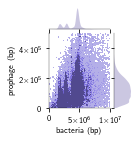

In [209]:
sizePhage = phagemeta.copy() # Avoid editing the main dataframe

# Create plot handle and plot data
gt2 = sns.JointGrid(x='normalise_by_prok_length', y='bp prophage', 
                   data=sizePhage[(sizePhage['Kept'] >= minPhages) & 
                                  (sizePhage['normalise_by_prok_length']  < 1E7) & 
                                  (sizePhage['bp prophage'] < 5E6)],
                  xlim=(0,1e7),ylim=(0,5E5), marginal_ticks=False,ratio=3, height=2) # counts normed by genome length

# Plot the 2D histogram
gt2.plot_joint(
    sns.histplot,color=colourDict.get('indigo'),pmax=.05)
gt2.plot_marginals(sns.kdeplot, linewidth=0,  fill=True, bw_adjust=2,color=colourDict.get('indigo'))


# Format axes
gt2.ax_joint.set_xlabel('bacteria (bp)')
gt2.ax_joint.set_ylabel('prophage (bp)')
gt2.ax_joint.set_xticks([0,5E6,1E7])
gt2.ax_joint.yaxis.set_major_formatter(MathTextSciFormatter("%1.0e")), gt2.ax_joint.xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
plt.setp(gt2.ax_marg_y.get_xaxis().get_offset_text(), visible=False)
plt.setp(gt2.ax_marg_x.get_yaxis().get_offset_text(), visible=False)

# Test plot

plt.savefig('../results/figures/Fig1a.png',dpi=600)

plt.show()

#### Calculate slope from Fig 1a
Use scipy stats for a linear regression on the data in fig 1a

In [205]:
t1 = sizePhage[(sizePhage['Kept'] >= minPhages) & 
                                  (sizePhage['normalise_by_prok_length']  < 1E7) & 
                                  (sizePhage['bp prophage'] < 5E6)]
slope, intercept, r_value, p_value, std_err = scp.stats.linregress(
    x=t1['normalise_by_prok_length'].astype(float),
               y=t1['bp prophage'].astype(float))
print('In Fig 1a the slope is:', slope, 'R2:',r_value**2, 'p-value:',p_value)

In Fig 1a the slope is: 0.029463031950391995 R2: 0.2627272195401632 p-value: 0.0


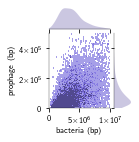

In [208]:
sizePhage = taxameta.copy()
# Subset the data
sizePhage = sizePhage[sizePhage['assembly_accession'].isin(newickList)]

# Create plot handle and plot data
gt = sns.JointGrid(x='normalise_by_prok_length', y='bp prophage', 
                   data=sizePhage[(sizePhage['Kept'] >= minPhages) & 
                                  (sizePhage['normalise_by_prok_length']  < 1E7) & 
                                  (sizePhage['bp prophage'] < 5E6)],
                  xlim=(0,1e7),ylim=(0,5E5), marginal_ticks=False,ratio=3, height=2) # counts normed by genome length

# Plot 2d histogram
gt.plot_joint(
    sns.histplot,color=colourDict.get('indigo'),pmax=.3,bins=200)
gt.plot_marginals(sns.kdeplot, linewidth=0,  fill=True, bw_adjust=2,color=colourDict.get('indigo'))

# Format axes
gt.ax_joint.set_xlabel('bacteria (bp)')
gt.ax_joint.set_ylabel('prophage (bp)')
gt.ax_joint.set_xticks([0,5E6,1E7])
gt.ax_joint.yaxis.set_major_formatter(MathTextSciFormatter("%1.0e")), gt.ax_joint.xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))

plt.setp(gt.ax_marg_y.get_xaxis().get_offset_text(), visible=False)
plt.setp(gt.ax_marg_x.get_yaxis().get_offset_text(), visible=False)
# plt.show
# Test plot

plt.savefig('../results/figures/Fig1c.png',dpi=600)

plt.show()

Do some small calculations needed for Fig 1b

In [40]:
# Create some bins to do the size counts for Fig 1b
sizePhage = phagemeta.copy()

minval=0
bins = list(np.arange(minval,1.2E7,1.4E6))
sizePhage['bin'] = pd.cut(sizePhage['normalise_by_prok_length'], bins)
sizePhage["bin_centres"] = sizePhage["bin"].apply(lambda x: x.mid).astype(np.float64)

# choose phylogenetic level for Fig 1b, do counts based on mean sizes for that order/class etc
level = 'class'
genomeSize = taxameta.groupby(level).mean()["normalise_by_prok_length"].values
numberGenomes = taxameta.groupby(level).size().values

#### Plot Figure 1

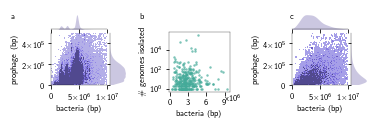

In [211]:
fig = plt.figure(figsize=(fig_width,0.5*fig_height))

# Set up gridspec
outer_gs = gridspec.GridSpec(nrows=1, ncols=1, figure=fig,  wspace=0.4,  hspace=0.5)
gs0 = gridspec.GridSpecFromSubplotSpec(nrows=8, ncols=22, subplot_spec=outer_gs[0], wspace=50, hspace=0)

## Comment the two lines below if required. The SeabornFig2Grid method places 1a and 1c generated above
## onto the gridspec panel. Note that there are some package incompatibilies. Figs 1a and 1c do not 
## export properly to formats outside of PDF however PDF creates white lines on those subplots.
SeabornFig2Grid(gt2, fig, gs0[0:6,0:6]) # Fig 1a
SeabornFig2Grid(gt, fig, gs0[0:6,16:22]) # Fig 1c

# Plot Fig 1b
f3_ax4 = fig.add_subplot(gs0[2:7,8:13])
sns.scatterplot(x=genomeSize,y=numberGenomes,s=6,alpha=0.7, linewidth=0, ax=f3_ax4,
                   color=colourDict.get('teal'))

# Do some axes formatting
f3_ax4.xaxis.offsetText.set_visible(False)
f3_ax4.text(0.93,  -0.15, 'x$10^6$', transform=f3_ax4.transAxes)
f3_ax4.set(yscale='log',yticks=[1,100,10000],xticks=[0,3E6,6E6,9E6],ylabel='\# genomes isolated',
           xlabel='bacteria (bp)')

# Add subfigure labels
f3_ax4.annotate('a',(0.03,0.85),xycoords='figure fraction',weight='bold')
f3_ax4.annotate('b',(0.375,0.85),xycoords='figure fraction',weight='bold')
f3_ax4.annotate('c',(0.78,0.85),xycoords='figure fraction',fontweight='bold')


plt.show()

# fig.savefig('../results/figures/panel1.svg', dpi=600)
# fig.savefig('../results/figures/panel1.pdf')

#### Get locations of KDE peaks in Fig 1c

In [62]:
df = sizePhage[(sizePhage['Kept'] >= 0)&
                           (sizePhage['normalise_by_prok_length']  < 1E8)&
                           (sizePhage['bp prophage'] < 10E6)  &
                           (sizePhage['assembly_accession'].isin(newickList))]

print('There are',df.shape[0],'genomes in Fig 1c')

There are 26328 genomes in Fig 1c


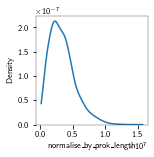

The peak for the bacterial dna total (bp) is at 2.27e+06


In [213]:
fig,ax1=plt.subplots(1,1,figsize=(2,2))
sns.kdeplot(df['normalise_by_prok_length'],ax=ax1, bw_adjust=2,cut=0.001)
plt.show()
x1 = ax1.lines[0].get_xdata() # Get the x data of the distribution
y1 = ax1.lines[0].get_ydata() # Get the y data of the distribution
maxid1 = np.argmax(y1) 
print('The peak for the bacterial dna total (bp) is at','{:.2e}'.format(x1[maxid1]))

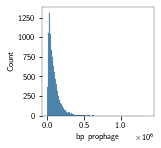

The peak for the genome's content (bp counts) of prophage is 1.99e+04


In [65]:
fig,ax2=plt.subplots(1,1,figsize=(2,2))
b = sns.histplot(df[df['bp prophage']>1]['bp prophage'])
plt.show()

x2 = [a.get_x() for a in b.patches] # Get the x data of the distribution
y2 = [a.get_height() for a in b.patches]  # Get the y data of the distribution
maxid2 = np.argmax(y2) # get peak idx
print('The peak for the genome\'s content (bp counts) of prophage is','{:.2e}'.format(x2[maxid2]))

## Fig 2: Phage size distributions

Create length dataframe to avoid editing the imported df.

Get number of genomes in each phyla.


In [66]:
phageLengthDf = allphagedf.copy()
phageLengthDf.rename(columns={'length':'bp'}, inplace=True)

phylumCounts = taxameta.groupby('phylum').count().reset_index()
phyCountDict = dict(zip(phylumCounts['phylum'],phylumCounts['assembly_accession']))

#### Get some size statistics

Grab the accessions of the genomes passing 100 contig thresholds

In [214]:
contigListTh = list(taxameta['assembly_accession'])

prophageSizePlot = phageLengthDf[phageLengthDf['notes'] == 'Kept']
prophageSizePlot = prophageSizePlot[prophageSizePlot['assembly_accession'].isin(contigListTh)]

print('Number of prophages in dataset',prophageSizePlot.shape[0],', median size is',prophageSizePlot['bp'].median())
print('Number >=20kb is',prophageSizePlot[prophageSizePlot['bp'] >= 20000].shape)

prophageSizePlotGTDB = prophageSizePlot[prophageSizePlot['assembly_accession'].isin(newickList)]


print('Median size in representative gtdb set is',prophageSizePlotGTDB['bp'].median())

Number of prophages in dataset 2668851 , median size is 23137.0
Number >20kb is (1558270, 7)
Median size in representative gtdb set is 25047.0


#### Look at the multimodality of individual species' phage size distributions 
Change nspecies to see the top n most abundant species in the database.

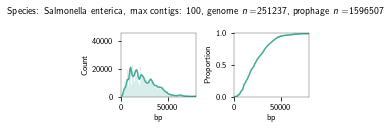

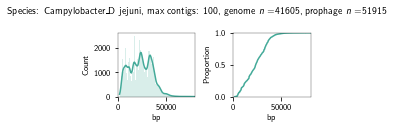

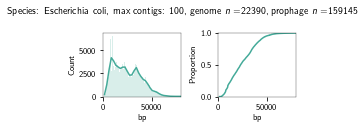

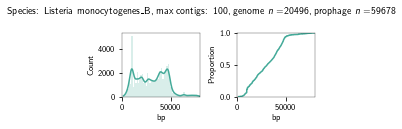

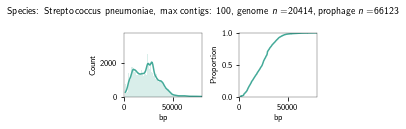

In [68]:
nspecies = 5

topSpecies = list(taxameta['species'].value_counts().head(nspecies).index)
for i in topSpecies:
    speciesName = i #'Staphylococcus aureus' # 'Salmonella enterica' # 'Escherichia coli'  # 'Mycobacterium tuberculosis' #  
    maxcont = maxContig

    prophageSizePlot2 = phageLengthDf[phageLengthDf['notes'] == 'Kept']

    prophageSizePlot2 = prophageSizePlot2[prophageSizePlot2['assembly_accession'].isin(
        list(taxameta[taxameta['species'] == speciesName]['assembly_accession']))]
    # prophageSizePlot2 = prophageSizePlot2[prophageSizePlot2['assembly_accession'].isin(list(phagemeta['assembly_accession']))]
    nval = prophageSizePlot2.shape[0]
    ngenomes = len(list(taxameta[taxameta['species'] == speciesName]['assembly_accession']))

    fig,ax = plt.subplots(1,2,figsize=(0.6*fig_width,0.5*fig_height))

    sns.histplot(x='bp', data=prophageSizePlot2, kde=True,ax=ax[0], 
                lw=0,alpha=0.2,color=colourDict.get('teal'))
    sns.ecdfplot(x='bp', data=prophageSizePlot2, ax=ax[1],color=colourDict.get('teal'))

    ax[0].set(xlim=[0,8E4])
    ax[1].set(xlim=[0,8E4])

    fig.suptitle('Species: '+speciesName+', max contigs: ' + str(maxContig) + r', genome $n=$'
                 + str(ngenomes)+ r', prophage $n=$' + str(nval))

    fig.tight_layout()
    plt.show()

#     fig.savefig('./figures/phagesizedist/Sp_'+speciesName+'_Cont_' + str(maxcont) + '_GenNum_'
#              + str(ngenomes)+ '_PhNum_' + str(nval), dpi=200)

## Generate Fig 2 panel

#### Generate dataframe for Fig 2a

In [220]:
# Minimum genome size
minval = 0
# Create bins
bins = list(np.arange(minval,1E7,1E6)) 

# Editable dataframe
sizePhage = phagemeta.copy()
sizePhage = sizePhage[sizePhage['normalise_by_prok_length'] > 0]
# Group by bins
sizePhage['bin'] = pd.cut(sizePhage['normalise_by_prok_length'], bins)
sizePhage["bin_centres"] = sizePhage["bin"].apply(lambda x: x.mid).astype(np.float64)
# choose taxonomic level
level = 'class'

# Exclude genomes with zero kept prophages
balancedSizePhage = sizePhage[sizePhage['assembly_accession'].isin(newickList)]
balancedSizePhage = balancedSizePhage[balancedSizePhage['Kept'] > 0]
bincentres = np.array(np.sort(sizePhage["bin_centres"].unique())[:-1] / 1E6).flatten()

#### Generate dataframe for Fig 2b
Use the representative gtdb genome set and the prophages which passed QC

In [221]:
prophageSizePlot = phageLengthDf[phageLengthDf['notes'] == 'Kept']
prophageSizePlot = prophageSizePlot[prophageSizePlot['assembly_accession'].isin(newickList)]

#### Generate dataframe for Fig 2c-2d

Use all data on genomes passing QC for the top 5 most abundant species in the database

In [308]:
# get top 5 most abundant species
topSpecies = list(taxameta['species'].value_counts().head(5).index)

# Filter on QC, kept prophages and genomes passing QC
prophageSizePlot2 = phageLengthDf[phageLengthDf['notes'] == 'Kept']
prophageSizePlot2 = prophageSizePlot2[prophageSizePlot2['assembly_accession'].isin(
    list(taxameta[taxameta['species'] == topSpecies[0]]['assembly_accession']))]
prophageSizePlot2 = prophageSizePlot2[prophageSizePlot2['assembly_accession'].isin(contigListTh)]

### Plot

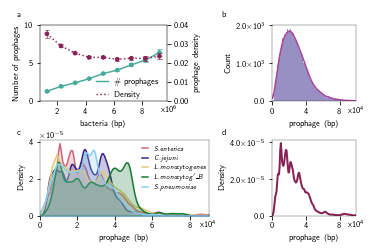

In [225]:
fig = plt.figure(figsize=(fig_width,fig_height))

# use gridspec due to the uneven subplot sizes
outer_gs = gridspec.GridSpec(nrows=2, ncols=1, figure=fig,  wspace=0.4,  hspace=0.5)
gs0 = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=15, subplot_spec=outer_gs[0], wspace=0, hspace=0)
gs1 = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=15, subplot_spec=outer_gs[1], wspace=0, hspace=0)

# Set up the axes on the  grid
ax0 = fig.add_subplot(gs0[0:,0:6])
ax1 = fig.add_subplot(gs0[0:,11:15])
ax4 = fig.add_subplot(gs1[0:,0:8])
ax2 = fig.add_subplot(gs1[0:,11:15])

# Put two seaborn point plots on the same axes
# first the total number of phages in a genome against genome size (2a)
with plt.rc_context({'lines.linewidth': 0.8}):
        s1 = sns.pointplot(x='bin_centres', y='Kept', data=balancedSizePhage,nboot=5000, ax = ax0, 
                  color=colourDict.get('teal'), alpha=0.6, s=8, 
                 capsize=.3, errwidth=0.6) 

ax3 = ax0.twinx()
with plt.rc_context({'lines.linewidth': 0.8}):
    s2 = sns.pointplot(x='bin_centres', y='Kept_normed', data=balancedSizePhage, ax=ax3, n_boot=5000,
                  color=colourDict.get('wine'), alpha=0.6, s=8, linestyles=':',
                 capsize=.3, errwidth=0.6)

# Do some formatting
ax3.xaxis.offsetText.set_visible(False) # scientific formatting is in the wrong spot, remove it
ax0.text(0.96,  -0.14,'x$10^6$', transform=ax0.transAxes)  # create new offset text in the right place
labels = ax0.get_xticklabels()
ax0.set(ylabel='Number of prophages',xlabel='bacteria (bp)',xticks =[0.75,2.75,4.75,6.75],xticklabels=[2,4,6,8],
      yticks=[0,5,10])
ax3.set(ylabel='prophage density',ylim=[0,0.04]) #
# ax.text(0.96,  -0.14,'x$10^6$', transform=ax0.transAxes)
# ax0.set(ylabel='\# prophages (norm)',ylim=[0,0.04])

# Set up the legend
L = ax0.legend(s1.lines[:1]+s2.lines[:1], ['A','G'],handlelength=1.5,loc='lower right',bbox_to_anchor=(1.0, -0.06),frameon=False)
L.get_texts()[0].set_text('\# prophages')
L.get_texts()[1].set_text('Density')


# Plot the histogram and KDE in 2b
sns.histplot(x='bp', data=prophageSizePlot, ax=ax1, kde=True, 
             kde_kws={'bw_adjust':1.3}, linewidth=0,color=colourDict.get('indigo'))

# Format axes
ax1.set(xlim=[1E2,1E5], xlabel='prophage (bp)')
ax1.yaxis.set_major_formatter(MathTextSciFormatter("%1.1e"))
ax1.set(xlim=[1E2,1E5], xlabel='prophage (bp)',xticks=[0,40000,80000],xticklabels=['0','4','8'],
           ylabel='Count')
ax1.text(0.9,  -0.15, 'x$10^4$', transform=ax1.transAxes)

ax1.lines[0].set_color(colourDict.get('purple'))


# Plot the salmonella KDE for the prophage distributions
sns.kdeplot(x='bp', data=prophageSizePlot2, ax=ax2, linewidth=2,color=colourDict.get('wine'))
ax2.set(xlim=[1E2,1E5], xlabel='prophage (bp)')
ax2.yaxis.set_major_formatter(MathTextSciFormatter("%1.1e"))
ax2.set(xlim=[1E2,1E5], xlabel='prophage (bp)',xticks=[0,40000,80000],xticklabels=['0','4','8'],
           ylabel='Density')
ax2.text(0.9,  -0.15, 'x$10^4$', transform=ax2.transAxes)

counter=0
colList = list(colourDict.values())
for i in topSpecies:
      
#     colourVal = colList[counter]
    
    speciesName = i #'Staphylococcus aureus' # 'Salmonella enterica' # 'Escherichia coli'  # 'Mycobacterium tuberculosis' #  
    maxcont = maxContig

    prophageSizePlot2 = phageLengthDf[phageLengthDf['notes'] == 'Kept']
    prophageSizePlot2 = prophageSizePlot2[prophageSizePlot2['assembly_accession'].isin(
        list(taxameta[taxameta['species'] == speciesName]['assembly_accession']))]
    nval = prophageSizePlot2.shape[0]
    ngenomes = len(list(taxameta[taxameta['species'] == speciesName]['assembly_accession']))
    
    sns.kdeplot(x='bp', data=prophageSizePlot2, ax=ax4, lw=1.5,fill=True, color=colList[counter])#,color=colourDict.get('teal'))
    counter=counter+1

#     fig.suptitle('Species: '+speciesName+', max contigs: ' + str(maxContig) + r', genome $n=$'
#                  + str(ngenomes)+ r', prophage $n=$' + str(nval))
ax4.set(xlim=[0,9E4], xlabel='prophage (bp)',xticks=[0,2E4,4E4,6E4,8E4],xticklabels=['0','2','4','6','8'])
ax4.text(0.95,  -0.15, 'x$10^4$', transform=ax4.transAxes)


custom_lines = [Line2D([0], [0], color=colList[0], lw=1.5),
                Line2D([0], [0], color=colList[1], lw=1.5),
                Line2D([0], [0], color=colList[2], lw=1.5),
                Line2D([0], [0], color=colList[3], lw=1.5),
                Line2D([0], [0], color=colList[4], lw=1.5)]

ax4.legend(custom_lines, ["$\it{S. enterica}$","$\it{C. jejuni}$","$\it{L. monocytogenes}$","$\it{L. monocytog'\_B}$","$\it{S. pneumoniae}$"], 
           handlelength=1,frameon=False, loc='upper right',bbox_to_anchor=(1.01, 1), fontsize='small')
# ax4.legend()

plt.annotate('a',(0.045,0.93),xycoords='figure fraction',weight='bold')
plt.annotate('b',(0.6,0.93),xycoords='figure fraction',weight='bold')
plt.annotate('c',(0.045,0.46),xycoords='figure fraction',fontweight='bold')
plt.annotate('d',(0.6,0.46),xycoords='figure fraction',fontweight='bold')


plt.show()

# fig.savefig('../results/figures/panel2.png',dpi=600,bbox_inches='tight')

### Check for multimodality in Fig 2b and Fig 2d

Note that this section will require R packages. Skip the following cells if you don't have R installed and working with your python environment.

Runs Hartigan's dip test on the prophage size distributions based on the representative gtdb genome set, and for S. enterica. There is also a subsampling bootstrap (Politis, Romano & Wolf Subsampling) to check the p-value behaviour further if required.

In [232]:
# import R packages
diptest=importr('diptest')
permute=importr('permute')
lattice=importr('lattice')
# spatstat=importr('spatstat')
pandas2ri.activate()

# Test representative gtdb set
prophageSizePlot = phageLengthDf[phageLengthDf['notes'] == 'Kept']
prophageSizePlot = prophageSizePlot[prophageSizePlot['assembly_accession'].isin(newickList)]

# Subsampling bootstrap to ensure reasonable behaviour of test
pvalboot = []
bootsize = 8 * np.sqrt(len(prophageSizePlot['bp']))

for i in range(0,500):
    dat = np.array(prophageSizePlot['bp'].sample(n=math.floor(bootsize)))
    pvalboot += [diptest.dip_test(dat)[1][0]]
print('p-value for Hartigan\'s dip test, balanced GTDB set is (note this may vary based on rng)',diptest.dip_test(dat)[1][0])
print('subsample bootsrapped p-value for Hartigan\'s dip test, balanced GTDB set is',np.mean(pvalboot))


# Test for Salmonella 
prophageSizePlot2 = phageLengthDf[phageLengthDf['notes'] == 'Kept']
prophageSizePlot2 = prophageSizePlot2[prophageSizePlot2['assembly_accession'].isin(
    list(taxameta[taxameta['species'] == topSpecies[0]]['assembly_accession']))]
prophageSizePlot2 = prophageSizePlot2[prophageSizePlot2['assembly_accession'].isin(contigListTh)]
bootsize2 = 8 * np.sqrt(len(prophageSizePlot2['bp']))

# Subsampling bootstrap to ensure reasonable behaviour of test
pvalboot2 = []
for i in range(0,500):
    dat = np.array(prophageSizePlot2['bp'].sample(n=math.floor(bootsize2)))
    pvalboot2 += [diptest.dip_test(dat)[1][0]]
    
dat = np.array(prophageSizePlot2['bp'].sample(n=71999))
print('p-value for Hartigan\'s dip test, Salmonella E. is (note this may vary based on rng)',diptest.dip_test(dat)[1])
print('subsample bootstrapped p-value for Hartigan\'s dip test, Salmonella E. is',np.mean(pvalboot2))

p-value for Hartigan's dip test, balanced GTDB set is (note this may vary based on rng) 0.9972692790983325
subsample bootsrapped p-value for Hartigan's dip test, balanced GTDB set is 0.9584179558470107
p-value for Hartigan's dip test, Salmonella E. is (note this may vary based on rng) [0.]
subsample bootstrapped p-value for Hartigan's dip test, Salmonella E. is 0.0


#### Check multimodality for top 5 most abundant species in database
This also requires R, take maximum number of genomes possible for these.

In [234]:
for i in range(0,5):
    maxcont = maxContig
    # Grab the prophages that pass QC
    prophageSizePlot2 = phageLengthDf[phageLengthDf['notes'] == 'Kept']
    # Filter based on taxa
    prophageSizePlot2 = prophageSizePlot2[prophageSizePlot2['assembly_accession'].isin(
    list(taxameta[taxameta['species'] == topSpecies[i]]['assembly_accession']))]
    prophageSizePlot2 = prophageSizePlot2[prophageSizePlot2['assembly_accession'].isin(contigListTh)]
    try:
        dat = np.array(prophageSizePlot2['bp'].sample(71999))
    except:
        dat = np.array(prophageSizePlot2['bp'])
        
    print('For',topSpecies[i], 'p-value for Hartigan\'s dip test for prophage size distribution',diptest.dip_test(dat)[1])

For Salmonella enterica p-value for Hartigan's dip test for prophage size distribution [0.]
For Campylobacter_D jejuni p-value for Hartigan's dip test for prophage size distribution [0.]
For Escherichia coli p-value for Hartigan's dip test for prophage size distribution [0.]
For Listeria monocytogenes_B p-value for Hartigan's dip test for prophage size distribution [0.]
For Streptococcus pneumoniae p-value for Hartigan's dip test for prophage size distribution [0.]


#### Get density calculations for the various data
Print out summary data.

In [338]:
print('MEANS')
print('the mean prophage density in the whole genome set >2Mbp is',taxameta[taxameta['Total Length (bp)'] > 2E6]['Kept_normed_all'].mean())
print('the mean prophage density in the whole lysogen set is',taxameta[taxameta['Kept'] >0]['Kept_normed_all'].mean())
print('the mean prophage density in the derepelicated gtdb lysogen set, Mbp>2 is',balancedSizePhage['Kept_normed_all'].mean())
print('the mean prophage density in the small genome set <2Mb',taxameta[taxameta['Total Length (bp)'] < 2E6]['Kept_normed_all'].mean())

print('MEDIANS')
print('the median prophage density in the whole genome set >2Mbp is',taxameta[taxameta['Total Length (bp)'] > 2E6]['Kept_normed_all'].median())
print('the median prophage density in the whole lysogen set is',taxameta[taxameta['Kept'] >0]['Kept_normed_all'].median())
print('the median prophage density in the derepelicated gtdb lysogen set, Mbp>2 is',balancedSizePhage['Kept_normed_all'].median())
print('the median prophage density in the small genome set <2Mb is',taxameta[taxameta['Total Length (bp)'] < 2E6]['Kept_normed_all'].median())

MEANS
the mean prophage density in the whole genome set >2Mbp is 0.030875024260459825
the mean prophage density in the whole lysogen set is 0.030793112190657917
the mean prophage density in the derepelicated gtdb lysogen set, Mbp>2 is 0.023861816395665973
the mean prophage density in the derepelicated gtdb lysogen set, Mbp>2 is 0.019254445983356207
the mean prophage density in the small genome set <2Mb 0.017590885673218263
MEDIANS
the median prophage density in the whole genome set >2Mbp is 0.030490234799033254
the median prophage density in the whole lysogen set is 0.030022290681985947
the median prophage density in the derepelicated gtdb lysogen set, Mbp>2 is 0.019762915261380798
the median prophage density in the small genome set <2Mb is 0.01603701212121067


In [237]:
lysogensdf = taxameta[taxameta['Kept'] > 0]
print('the mean prophage density in the small genome lysogens <2Mb is',lysogensdf[lysogensdf['Total Length (bp)'] < 2E6]['Kept_normed_all'].mean())

the mean prophage density in the small genome lysogens <2Mb is 0.025774732675932686


In [238]:
print('Salmonella Enterica prophage density is', taxameta[(taxameta['species']=='Salmonella enterica') & (taxameta['Kept'] > 0)]['Kept_normed_all'].median())
print('E coli prophage density is', taxameta[(taxameta['species']=='Escherichia coli') & (taxameta['Kept'] > 0)]['Kept_normed_all'].median())

Salmonella Enterica prophage density is 0.032948408799397734
E coli prophage density is 0.03278842724523899


## Figure 3

Use the genbank assembly summary to get additional metadata e.g. MAG status, as well as isolation date (proxied as sample date)

In [239]:
print('there are',len(taxameta[taxameta['isolation_date'].notnull()]),'genomes with date metadata')

there are 75378 genomes with date metadata


#### Plot 3a
Generate dataframe of genomes which have date metadata and plot a joint KDE with prophage density

/Users/JFisher/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:1668: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


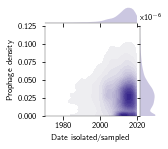

In [240]:
tmpKDE = taxameta[taxameta['isolation_date'].notnull()]

# create jointgrid and plot data
gr = sns.JointGrid(x='isolation_date', y='Kept_normed', data=tmpKDE,xlim=(1970, 2020), ylim=(0, 0.125), height=2) # counts normed by genome length
gr.plot_joint(sns.kdeplot, fill=True, cmap="light:"+colourDict.get('indigo'), n_levels=25,cbar=False)
gr.plot_marginals(sns.kdeplot, linewidth=0,  fill=True, bw_adjust=1.4,color=colourDict.get('indigo')) # "#03012d"

# annotate axes and plot
gr.ax_joint.set_xlabel('Date isolated/sampled')
gr.ax_joint.set_ylabel('Prophage density')

gr.ax_joint.yaxis.offsetText.set_visible(False)
gr.ax_joint.text(x = 1.03, y = 1.07, s = 'x$10^{-6}$', transform=gr.ax_joint.transAxes)#,xy=(0.01,1), xycoords='figure fraction')
plt.setp(gr.ax_marg_y.get_yticklabels(), visible=False)

plt.show()

### Generate metadata for plots 3c-3e
Choose phylogenetic level and get date of when phylum first appeared in database

In [266]:
# what phylogenetic level for 
level = 'phylum'

normtype = 'Kept_normed'
earliestIsoltionDf = taxameta[~taxameta['isolation_date'].isna()][[level,'isolation_date']].groupby(level).min().add_suffix('min').reset_index().sort_values(by='isolation_datemin')
earliestDict = dict(zip(earliestIsoltionDf[level],earliestIsoltionDf['isolation_datemin']))
taxameta['isolation_datemin'] = taxameta[level].map(earliestDict)

earliestIsoltionDf = taxameta[~taxameta['isolation_date'].isna()][[level,'isolation_date']].groupby(level).min().add_suffix('min').reset_index().sort_values(by='isolation_datemin')
earliestDict = dict(zip(earliestIsoltionDf[level],earliestIsoltionDf['isolation_datemin']))
firstIsolated = taxameta.groupby('phylum').mean().reset_index()
firstIsolated = firstIsolated[firstIsolated['isolation_datemin'] > 1850]

Collate information for how many potential prophage were picked up by phispy and how many matched to the DBs

In [267]:
# Get the full phage data dump and pivot dataframe to format we need
phageLengthDf2 = phageLengthDf[phageLengthDf['assembly_accession'].isin(contigListTh)]
procKept = phageLengthDf2.groupby(['assembly_accession','notes']).sum().reset_index()
procKept = procKept.pivot(index='assembly_accession', columns='notes', values='bp').reset_index()
procKept = procKept.rename_axis(None, axis="columns")
procKept.fillna(0, inplace=True)

# create new discard column 
procKept['discard'] = procKept['Dropped. No genes were identified as phage genes'
                              ] + procKept['Dropped. Not enough genes'
                                          ] + procKept['Dropped. Region too small (Not enough genes)']

# calculate proportions of how much data was kept
tmp2 = taxameta[['assembly_accession',level,'bp prophage']].merge(procKept,on='assembly_accession')
keptExplore = pd.DataFrame(tmp2.groupby(level)["discard"].mean()).reset_index()
# Group at requested taxonomic level from above
keptExplore['bp prophage'] = tmp2.groupby(level)["bp prophage"].mean().values
#
keptExplore['isolation_datemin'] = keptExplore[level].map(earliestDict)
keptExplore['bp found'] = keptExplore['discard'].values + keptExplore['bp prophage'].values
keptExplore['prop kept'] = keptExplore['bp prophage'].values / (keptExplore['bp prophage'].values 
                                                                + keptExplore['discard'].values) # +1

 

In [268]:
# Generate annual bins for plot 3c 
bins2 = np.arange(1810,2024,1)
yearTaxa2 = taxameta.copy()
yearTaxa2 = yearTaxa2[~yearTaxa2['isolation_date'].isnull()]
yearTaxa2 = yearTaxa2[yearTaxa2['isolation_date'] < 2019]
yearTaxa2['bin'] = pd.cut(taxameta['isolation_date'], bins2)
yearTaxa2["bin_centres"] = yearTaxa2["bin"].apply(lambda x: x.mid).astype(np.float64)
binsets3 = list(yearTaxa2['bin_centres'].unique())

# initialise list for non-lysogenic genome counts
yearList3 = []

# counts of how many non-lysogenic genomes there were in total
for binVal in binsets3:
    num = len(yearTaxa2[yearTaxa2['bin_centres'] == binVal]) # how many genomes
    subDf = yearTaxa2[yearTaxa2['bin_centres'] == binVal] # grab the genomes from that year
    numzeros = len(subDf[subDf['Kept'] == 0]) # count how many were non lysogens
    yearList3 += [numzeros] # add to the list

#### Plot fig 3

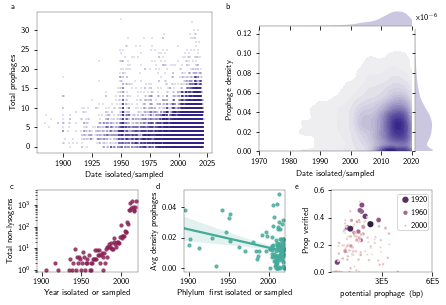

In [269]:
fig = plt.figure(figsize=(fig_width*1.1,1.2*fig_height))
# plt.figure()

gs = gridspec.GridSpec(5, 6)

f3_ax1 = fig.add_subplot(gs[0:3, 0:3])
sns.scatterplot(x='isolation_date', y='Kept', ax = f3_ax1, 
                data=taxameta[(taxameta['isolation_date'].notnull()) & (taxameta['isolation_date'] > 1850)], 
                marker='+', color=colourDict.get('indigo'), alpha=0.6, s=8)

f3_ax2 = SeabornFig2Grid(gr, fig, gs[0:3, 3:6])

f3_ax3 = fig.add_subplot(gs[3:5, 0:2])
sns.scatterplot(x=binsets3,y=yearList3, linewidth=0, ax=f3_ax3,s=18,alpha=0.85, 
                color=colourDict.get('wine'))
f3_ax3.set(xlabel='Year isolated or sampled', ylabel='Total non-lysogens', yscale='log',
          xlim=[1894,2021],ylim=[0.8,5E3])

f3_ax4 = fig.add_subplot(gs[3:5, 4:6])
sns.scatterplot(x='bp found',y='prop kept', data=keptExplore[keptExplore['isolation_datemin']>=1900],
               hue='isolation_datemin', size='isolation_datemin',sizes=(40,3),
               palette=sns.cubehelix_palette(as_cmap=True).reversed(), ax=f3_ax4)
f3_ax4.set(xticks=[3E5,6E5],xticklabels=['3E5','6E5'],
           xlabel='potential prophage (bp)',ylabel='Prop verified', xlim=[0,6E5], ylim=[0,0.6])

handles, labels = f3_ax4.get_legend_handles_labels()
c1 = handles[0].get_facecolors()
c2 = handles[2].get_facecolors()
c3 = handles[4].get_facecolors()

handles[4].set_facecolors(c1)
handles[0].set_facecolors(c3)

handles[0].set_sizes([3])
handles[4].set_sizes([40])
handles[2].set_sizes([18.5])

handles[4].set_edgecolors(None)
handles[2].set_edgecolors(None)
handles[0].set_edgecolors(None)

h2 = [handles[4],handles[2],handles[0]]
l2 = [labels[0],labels[2],labels[4]]

legend2 = f3_ax4.legend(h2,l2,frameon=True,handletextpad=-0.3, loc='upper right',
                        borderpad=0.06)

f3_ax5 = fig.add_subplot(gs[3:5, 2:4])
sns.regplot(x=firstIsolated['isolation_datemin'],y=firstIsolated[normtype], ax=f3_ax5,
           scatter_kws={'s':10},color=colourDict.get('teal'))
f3_ax5.set(xlim=[1894,2021],xlabel='Phlylum first isolated or sampled',ylabel='Avg density prophages')
f3_ax1.set(ylabel='Total prophages',xlabel='Date isolated/sampled')

gs.tight_layout(fig)

plt.annotate('a',(0.024,0.97),xycoords='figure fraction',weight='bold')
plt.annotate('b',(0.506,0.97),xycoords='figure fraction',weight='bold')
plt.annotate('c',(0.023,0.38),xycoords='figure fraction',fontweight='bold')
plt.annotate('d',(0.35,0.38),xycoords='figure fraction',fontweight='bold')
plt.annotate('e',(0.66,0.38),xycoords='figure fraction',fontweight='bold')

plt.show()

# fig.savefig('../results/figures/fig3_panel.png', dpi=600)
fig.savefig('../results/figures/fig3_panel.pdf')

#### Slope in Figure 3a

Calculate regression and get slope and p value

In [270]:
slope, intercept, r_value, p_value, std_err = scp.stats.linregress(
    x=taxameta[taxameta['isolation_date'].notnull()]['isolation_date'].astype(float),
               y=taxameta[taxameta['isolation_date'].notnull()]['Kept'])
print('slope', slope, 'R2',r_value**2, 'p-value',p_value)

slope -0.02348775141277848 R2 0.007297238797020037 p-value 4.5091834662821327e-122


#### Mann-Whitney for significant difference of prophage densities between MAG and non-MAG

Run a Mann-Whitney U-test to see whether there is a significant difference in prophage densities between MAG or non-MAG genomes

In [271]:
print('means are (%): MAG ',
      100*np.mean(taxameta[taxameta['assembly_accession'].isin(magAccs)]['Kept_normed'].values),
      ', non-MAG ', 
      100*np.mean(taxameta[~taxameta['assembly_accession'].isin(magAccs)]['Kept_normed'].values))
print('medians are (%): MAG ',
      100*np.median(taxameta[taxameta['assembly_accession'].isin(magAccs)]['Kept_normed'].values), 
      ', non-MAG ',
      100*np.median(taxameta[~taxameta['assembly_accession'].isin(magAccs)]['Kept_normed'].values))
print(mannwhitneyu(taxameta[taxameta['assembly_accession'].isin(magAccs)]['Kept_normed'].values, 
             +taxameta[~taxameta['assembly_accession'].isin(magAccs)]['Kept_normed'].values))

means are (%): MAG  1.3997576859889465 , non-MAG  3.1639019667005024
medians are (%): MAG  0.7251512016685987 , non-MAG  3.013792948939626
MannwhitneyuResult(statistic=1962800743.0, pvalue=0.0)


#### Regression showing near uniform behaviour in Fig 3e

In [272]:
slope, intercept, r_value, p_value, std_err = scp.stats.linregress(
    keptExplore['bp found'],keptExplore['prop kept'])
print('slope', slope, 'R2',r_value**2, 'p-value',p_value)

slope 1.4952764133061296e-07 R2 0.007452171161303832 p-value 0.321301894353903


#### Proportion of discarded prophages due to insufficent DB matches or size of segment

In [273]:
dreplist = phageLengthDf[phageLengthDf['assembly_accession'].isin(newickList)]
countsDf = dreplist.groupby('notes').count()
totalcount = countsDf['assembly_accession'].sum()
countsDf['proportions'] = countsDf['assembly_accession'] / totalcount

print('proportion of discarded genes from PhiSpy due to not being in the database or too few genes:',
      countsDf.loc['Dropped. No genes were identified as phage genes','proportions'] + 
      countsDf.loc['Dropped. Not enough genes','proportions'])

proportion of discarded genes from PhiSpy due to not being in the database or too few genes: 0.6579446723191236


In [274]:
print('proportion of genes meeting phispy QC but no matches to database is.',countsDf.loc['Dropped. No genes were identified as phage genes','proportions'] / (countsDf.loc['Dropped. No genes were identified as phage genes','proportions'] 
                                                                                  + countsDf.loc['Kept','proportions']))

print('thus the proportion of kept phage genes is',1-countsDf.loc['Dropped. No genes were identified as phage genes','proportions'] / (countsDf.loc['Dropped. No genes were identified as phage genes','proportions'] 
                                                                                  + countsDf.loc['Kept','proportions']))

proportion of genes meeting phispy QC but no matches to database is. 0.6563047665762299
thus the proportion of kept phage genes is 0.34369523342377006


## Fig 4

Country and phyla sampling heatmap. Firstly, calculate some statistics and metadata.

In [275]:
# Minimum number of genomes to be included in country counts
genomen = 10 
# How many phyla to consider
numphyl = 1

tmpc = pd.DataFrame(taxameta.groupby('isolation_country').count()['assembly_accession'] > genomen)
smalltmp = taxameta[taxameta['isolation_country'].isin(tmpc[tmpc['assembly_accession']].index)]

# Take top 15 countries and sort dataframe
topcountries = list(smalltmp.groupby('isolation_country').count()['assembly_accession'].sort_values(ascending=False).index)[0:15]
tmpc = pd.DataFrame(taxameta.groupby('phylum').count()['assembly_accession'] > numphyl)
smalltmp = smalltmp[smalltmp['phylum'].isin(tmpc[tmpc['assembly_accession']].index)]
topphyla = list(smalltmp.groupby('phylum').count()['assembly_accession'].sort_values(ascending=False).index)

In [319]:
print('the genomes with country metadata included',taxameta[~taxameta['isolation_country'].isnull()].shape[0],'genomes')

taxameta.groupby('isolation_country').count()['assembly_accession'].sort_values(ascending=False).head(3)

the genomes with country metadata included 76070 genomes


isolation_country
United States     25569
China              6822
United Kingdom     4687
Name: assembly_accession, dtype: int64

In [311]:
print('out of the entire dataset, the taxa groups with the most samples are')
print(taxameta.groupby('phylum').count()['assembly_accession'].sort_values(ascending=False).head(3))

print('these phyla constitute',taxameta.groupby('phylum').count()['assembly_accession'].sort_values(ascending=False).head(3).reset_index()['assembly_accession'].sum()/ taxameta.shape[0], 'of the dataset')

out of the entire dataset, the taxa groups with the most samples are
phylum
Proteobacteria      353392
Firmicutes          109590
Campylobacterota     60021
Name: assembly_accession, dtype: int64
these phyla constitute 0.9102162926041435 of the dataset


In [318]:
print('total predicted phage HMM hits matching VOG for these clades is')
for i in taxameta.groupby('phylum').count()['assembly_accession'].sort_values(ascending=False).head(3).reset_index()['phylum']:
    print(i, ':',keptExplore[keptExplore['phylum'] == i]['prop kept'].values)

total predicted phage HMM hits matching VOG for these clades is
Proteobacteria : [0.78269969]
Firmicutes : [0.54838675]
Campylobacterota : [0.37417919]


In [282]:
procKept['discard_small'] = procKept['Dropped. No genes were identified as phage genes']
print('discarded',procKept['discard_small'].mean())

tmp2 = taxameta[['assembly_accession',level,'bp prophage']].merge(procKept,on='assembly_accession')
keptExplore = pd.DataFrame(tmp2.groupby(level)["discard_small"].mean()).reset_index()
keptExplore['bp prophage'] = tmp2.groupby(level)["bp prophage"].mean().values
keptExplore['isolation_datemin'] = keptExplore[level].map(earliestDict)
keptExplore['bp found'] = keptExplore['discard_small'].values + keptExplore['bp prophage'].values
keptExplore['prop kept'] = keptExplore['bp prophage'].values / (keptExplore['bp prophage'].values
                                                                + keptExplore['discard_small'].values)
keptExplore.fillna(0, inplace=True)

How many matches to VOG on the least sequenced phyla?

In [337]:
# Count how many times each phylum is sampled
leastsequenced = taxameta.groupby('phylum').count()['assembly_accession'].sort_values(ascending=False).reset_index()
# Ensure there are at least 5 genomes sampled for that phylum
leastsequenced = leastsequenced[leastsequenced['assembly_accession'] >= 5]
# grab the 5 least sequenced
tenLeastSequenced = list(leastsequenced.tail(5).reset_index()['phylum'])
print('Proportion hitting to VOG on the 5 least sequenced phyla (that have at least 5 genomes sequenced) is',np.mean(keptExplore[keptExplore['phylum'].isin(tenLeastSequenced)]['prop kept']))

Proportion hitting to VOG on the 5 least sequenced phyla (that have at least 5 genomes sequenced) is 0.14335650142139295


And across the full database (per phylum, not weighted by sample size)

In [323]:
print('for all phyla the hits average', np.mean(keptExplore.groupby('phylum').mean()['prop kept']))

for all phyla the hits average 0.29932021200183556


#### Generate heatmap
Figure 4 country heatmap - group counts by country and phylum and pivot

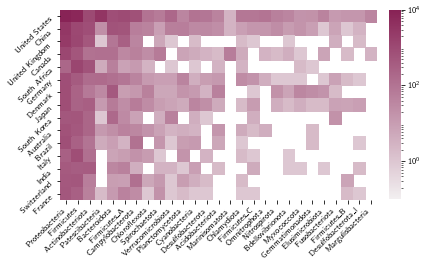

In [324]:
df_m = smalltmp.groupby(["isolation_country", "phylum"]).size().unstack(level=0)

# Sort and reindex so top counts are in the top left and lowest bottom right|
df_m.index = pd.CategoricalIndex(df_m.index, categories= topphyla)
df_m.sort_index(level=0, inplace=True)
df_m = df_m.reindex(columns=topcountries)
df_m = df_m.iloc[0:27,:]

# Create log colour scale for visualisation
lognorm = LogNorm(vmin=0.1, vmax=1E4)
fig, ax = plt.subplots(1,1,figsize=(fig_width,1*fig_height))
# Create colourbar stats
cbar_ax = fig.add_axes([0.93, 0.13, .03, 0.75])

# plot
g = sns.heatmap(df_m.T,norm=lognorm,
            cmap = sns.light_palette(colourDict.get("wine"), as_cmap=True),
           ax=ax, cbar_ax = cbar_ax, vmin=0.1,cbar_kws={"ticks":[1E0,1E2,1E4]})

# Figure and axes formatting
ax.set(xlabel='',ylabel='')
cbar_ax.set_ylim(.1,1E4)
plt.yticks(rotation=0) 
g.set_yticklabels(g.get_yticklabels(), rotation = 45,va='top')
g.set_xticklabels(g.get_xticklabels(), rotation = 45,ha='right')


plt.show()
fig.savefig('../results/figures/countries.png',dpi=600,bbox_inches = "tight")


## Generate metadata to import to iTOL for Figure 5

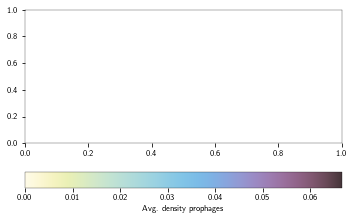

In [339]:
# Colour list
iridescent = ['#FEFBE9', '#FCF7D5', '#F5F3C1', '#EAF0B5', '#DDECBF',
        '#D0E7CA', '#C2E3D2', '#B5DDD8', '#A8D8DC', '#9BD2E1',
        '#8DCBE4', '#81C4E7', '#7BBCE7', '#7EB2E4', '#88A5DD',
        '#9398D2', '#9B8AC4', '#9D7DB2', '#9A709E', '#906388',
        '#805770', '#684957', '#46353A']

# Generate colourmap for 19557 genomes
iridCM = colors.LinearSegmentedColormap.from_list('mycols',iridescent, N=19557)
norm = colors.Normalize(vmin=0, vmax=28360)
iridArr = iridCM(np.linspace(0, 1, 19557))

# Generate colour map and colour bar
balancedTaxDf = taxameta[taxameta['assembly_accession'].isin(newickList)]
phsum = balancedTaxDf.groupby('phylum').mean().reset_index()
cmap1 = iridCM
norm = Normalize(vmin=phsum['Kept_normed'].min(), vmax=phsum['Kept_normed'].max())

# Do the colour mapping
m = cm.ScalarMappable(norm=norm, cmap=cmap1)

# Generate a list of colours for each phylum based on their average prophage density
collist = [mpl.colors.to_hex(a) for a in m.to_rgba(phsum['Kept_normed'])]

# Create colourbar for figure 5
fig, ax = plt.subplots(1,1)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap1),ax=ax,orientation='horizontal',
             label="Avg. density prophages")
plt.show()

fig.savefig('../results/figures/colorbar.png',dpi=200)

In [305]:
collist

['#92cee3',
 '#d3e8c7',
 '#dbebc1',
 '#afdbda',
 '#c8e5cf',
 '#daebc1',
 '#c8e5cf',
 '#bce0d5',
 '#8acae5',
 '#d9ebc2',
 '#fefbe9',
 '#d4e8c7',
 '#d6e9c5',
 '#b1dcd9',
 '#fefbe9',
 '#f1f2bc',
 '#46353a',
 '#e6efb8',
 '#fefbe9',
 '#dcecc0',
 '#dbebc1',
 '#c1e2d3',
 '#fefbe9',
 '#c8e5ce',
 '#f4f3bf',
 '#8ecce4',
 '#cfe7cb',
 '#f6f3c3',
 '#d7eac4',
 '#b6ddd8',
 '#f8f4c8',
 '#afdbda',
 '#bfe2d3',
 '#cfe7ca',
 '#cfe7ca',
 '#ddecbf',
 '#c5e4d0',
 '#f9f5cb',
 '#e8efb6',
 '#b9dfd6',
 '#e4eeba',
 '#e0edbd',
 '#fcf8d8',
 '#f9f5cd',
 '#fdf9df',
 '#a5d7dd',
 '#b6ddd8',
 '#e8efb6',
 '#b4ddd8',
 '#c5e4d0',
 '#cae5cd',
 '#c8e5cf',
 '#fdf9e1',
 '#daebc2',
 '#eff1bb',
 '#91cde3',
 '#8dcbe4',
 '#85a8df',
 '#7bbde7',
 '#7ec0e7',
 '#acd9db',
 '#88c8e5',
 '#96d0e2',
 '#b9dfd6',
 '#82ace1',
 '#cce6cc',
 '#fefae5',
 '#ecf1b8',
 '#dfedbd',
 '#ecf1b8',
 '#e3eebb',
 '#e9f0b6',
 '#d2e8c8',
 '#fefbe9',
 '#82c5e7',
 '#e7efb7',
 '#c1e3d2',
 '#faf6d0',
 '#d9ebc2',
 '#f0f2bb',
 '#e4eeb9',
 '#b9dfd6',
 '#909bd5',
 '#f

## Supplementary Figures

#### Figure S1
Scatterplot and regression of the total base pairs of prophage DNA in a genome against total number of prophages found in a genome (all data)

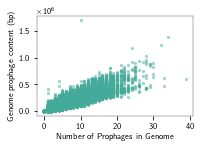

The regression statistics for this plot are: slope 22489.184448265118 R2 0.8176869619584214 p-value 0.0


In [201]:

numPhageBP = taxameta.copy()

fig, ax = plt.subplots(1,1,figsize=(0.5*fig_width,0.6*fig_height))

sns.scatterplot(x='Kept',y='bp prophage', data = numPhageBP,color=colourDict.get('teal'), s=11, alpha=0.5, linewidth=0)

ax.set(xlabel='Number of Prophages in Genome',ylabel='Genome prophage content (bp)')

plt.tight_layout()
plt.show()

slope, intercept, r_value, p_value, std_err = scp.stats.linregress(
    x=taxameta['Kept'].astype(float),
               y=taxameta['bp prophage'].astype(float))
print('The regression statistics for this plot are: slope', slope, 'R2',r_value**2, 'p-value',p_value)

fig.savefig('../results/figures/SI/Fig_S1_bp_vs_counts_prophage.png',dpi=300)

#### Figure S2

All genomes, full size range

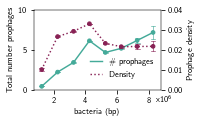

total number of genomes is 575116


In [340]:
minval = 0
bins = list(np.arange(minval,1.2E7,1.4E6))  # 1.2
# bins += [2E8]
sizePhage = phagemeta.copy()
sizePhage = sizePhage[(sizePhage['normalise_by_prok_length'] > 5E4) & (sizePhage['Kept'] >= 0)]
# sizePhage = sizePhage[sizePhage['assembly_accession'].isin(newickList)]

sizePhage['bin'] = pd.cut(sizePhage['normalise_by_prok_length'], bins)
sizePhage["bin_centres"] = sizePhage["bin"].apply(lambda x: x.mid).astype(np.float64)

fig, ax = plt.subplots(1,1,figsize=(0.5*fig_width,0.5*fig_height))
with plt.rc_context({'lines.linewidth': 0.8}):
        s1 = sns.pointplot(x='bin_centres', y='Kept', data=sizePhage,nboot=5000, ax = ax, 
                  color=colourDict.get('teal'), alpha=0.6, s=8, 
                 capsize=.3, errwidth=0.6) 

ax0 = ax.twinx()
with plt.rc_context({'lines.linewidth': 0.8}):
    s2 = sns.pointplot(x='bin_centres', y='Kept_normed', data=sizePhage, ax=ax0, n_boot=5000,
                  color=colourDict.get('wine'), alpha=0.6, s=8, linestyles=':',
                 capsize=.3, errwidth=0.6)

ax0.xaxis.offsetText.set_visible(False)
labels = ax0.get_xticklabels()
ax.set(ylabel='Total number prophages',xlabel='bacteria (bp)',xticks =[0.75,2.75,4.75,6.75],xticklabels=[2,4,6,8],
      yticks=[0,5,10])
ax.text(0.96,  -0.14,'x$10^6$', transform=ax0.transAxes)
ax0.set(ylabel='Prophage density',ylim=[0,0.04])

L = ax0.legend(s1.lines[:1]+s2.lines[:1], ['A','G'],handlelength=1.5,loc='lower right',bbox_to_anchor=(1.0, 0.05),frameon=False)
L.get_texts()[0].set_text('\# prophages')
L.get_texts()[1].set_text('Density')

plt.tight_layout()
plt.show()
print('total number of genomes is', phagemeta.shape[0])

fig.savefig('../results/figures/SI/Fig_S1_fulldensity.png',dpi=300)

#### Figure S3. Plot Figs 3a and 3b assuming sample date is the isolation date for all genomes.

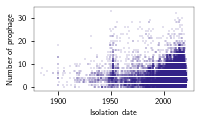

In [341]:
taxameta['isolation_date_proxy'] = taxameta.apply(lambda x: updateDate(x,magDateDict),axis=1)

fig,ax=plt.subplots(1,1,figsize=(0.5*fig_width,0.5*fig_height))

sns.scatterplot(x='isolation_date_proxy', y='Kept', ax = ax, 
                data=taxameta[taxameta['isolation_date'] > 1850], 
                marker='+', color=colourDict.get('indigo'), alpha=0.6, s=8)
ax.set(ylabel = 'Number of prophage',xlabel='Isolation date')
plt.tight_layout()
plt.show()
fig.savefig('../results/figures/SI/FigS2a.png',dpi=300)

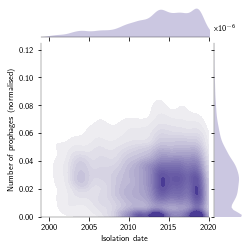

In [181]:
tmpKDE2 = taxameta[taxameta['isolation_date_proxy'] > 2000]

gr = sns.JointGrid(x='isolation_date_proxy', y='Kept_normed', data=tmpKDE2,xlim=(1999, 2020), ylim=(0, 0.125), height=fig_height) # counts normed by genome length
gr.plot_joint(sns.kdeplot, fill=True, cmap="light:"+colourDict.get('indigo'), n_levels=25,cbar=False)
gr.plot_marginals(sns.kdeplot, linewidth=0,  fill=True, bw_adjust=1.4,color=colourDict.get('indigo')) # "#03012d"

gr.ax_joint.set_xlabel('Isolation date')
gr.ax_joint.set_ylabel('Number of prophages (normalised)')

gr.ax_joint.yaxis.offsetText.set_visible(False)
gr.ax_joint.text(x = 1.03, y = 1.07, s = 'x$10^{-6}$', transform=gr.ax_joint.transAxes)#,xy=(0.01,1), xycoords='figure fraction')
plt.setp(gr.ax_marg_y.get_yticklabels(), visible=False)

plt.show()

gr.savefig('../results/figures/SI/FigS2b.png',dpi=300)

#### Figure S4. Do the lysogens or non-lysogens become more frequent over time? Or is it consistent?

Note that the regression is fitted on data up until 2012, and due to the log scale, 1 has been added to both the x and y data to prevent undefined values. 

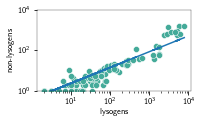

In [182]:
tp = phagemeta[phagemeta['isolation_date'].notnull()]

bins2 = np.arange(1810,2020,1)
yearTaxa2 = phagemeta.copy()
yearTaxa2 = yearTaxa2[~yearTaxa2['isolation_date'].isnull()]
yearTaxa2 = yearTaxa2[yearTaxa2['isolation_date'] <= 2019]
yearTaxa2['bin'] = pd.cut(phagemeta['isolation_date'], bins2)
yearTaxa2["bin_centres"] = yearTaxa2["bin"].apply(lambda x: x.mid).astype(np.float64)
# yearTaxa_dropNaN = yearTaxa[~yearTaxa['isolation_date'].isna()]
binsets3 = list(yearTaxa2['bin_centres'].unique())
yearList3 = []
yearList4 = []

for binVal in np.sort(binsets3):
    num = len(yearTaxa2[yearTaxa2['bin_centres'] == binVal])
    subDf = yearTaxa2[yearTaxa2['bin_centres'] == binVal]
    numzeros = len(subDf[subDf['Kept'] == 0])
    numzeros2 = len(subDf[subDf['Kept'] != 0])
    yearList3 += [numzeros]
    yearList4 += [numzeros2]


xi= np.array(yearList4)+1
yi = np.array(yearList3)+1

fig, ax = plt.subplots(1,1,figsize=(0.5*fig_width,0.5*fig_height))
ax=sns.scatterplot(x=xi,y=yi, color=colourDict.get('teal'),lw=0)
ax.set(yscale='log',ylim=[1,1E4],xscale='log', ylabel='non-lysogens',xlabel='lysogens')  


idx = len(binsets3) - 7
m, b = np.polyfit(np.log(xi[0:idx]), np.log(yi[0:idx]), 1)

y_fit = np.exp(m*np.array(np.log(xi) + b))
plt.plot(np.array(xi), y_fit)

plt.tight_layout()
plt.show()

fig.savefig('../results/figures/SI/S2-lysogens_non-lysogens.png',dpi=200)

### Figure S5: qualitative consistency for Figure 3d at different phylogenetic levels (normalised prophage counts against first isolated) 

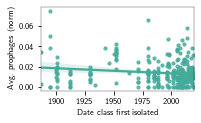

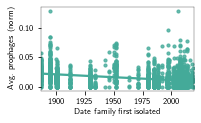

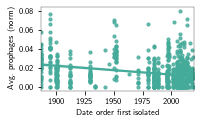

In [183]:
levels = ['class','family','order']

for lev in levels:
    normtype = 'Kept_normed'
    earliestIsoltionDf = taxameta[~taxameta['isolation_date'].isna()][[lev,'isolation_date']
                                                                     ].groupby(lev).min().add_suffix('min').reset_index().sort_values(by='isolation_datemin')
    earliestDict = dict(zip(earliestIsoltionDf[lev],earliestIsoltionDf['isolation_datemin']))

    firstIsolated = taxameta.groupby(lev).mean().reset_index()
    firstIsolated = firstIsolated[firstIsolated['isolation_datemin'] > 1850]

    fig,ax=plt.subplots(1,1,figsize=(0.5*fig_width,0.5*fig_height))

    sns.regplot(x=firstIsolated['isolation_datemin'],y=firstIsolated[normtype],
               scatter_kws={'s':10},color=colourDict.get('teal'), ax=ax)

    ax.set(xlabel='Date '+lev+' first isolated',ylabel='Avg. prophages (norm)')
    plt.tight_layout()
    plt.show()
    fig.savefig('../results/figures/SI/S4_'+lev+'.png',dpi=200)

### Figure S6: Standard deviation of prophage density against prophage density

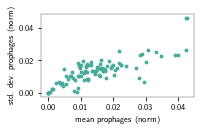

In [184]:
balancedTaxDf = taxameta[taxameta['assembly_accession'].isin(newickList)]
level = 'phylum'
meanDf = balancedTaxDf.groupby(level).mean().reset_index()
stdDf = balancedTaxDf.groupby(level).std().reset_index()

fig, ax = plt.subplots(1,1, figsize=(0.5*fig_width,0.5*fig_height))
plt.scatter(meanDf['Kept_normed'], stdDf['Kept_normed'],color=colourDict.get('teal'), s=8)

ax.set(xlabel='mean prophages (norm)',ylabel='std. dev. prophages (norm)')
plt.tight_layout()
plt.show()

fig.savefig('../results/figures/SI/S6.png',dpi=200)